# ROS ALE Figure 4

Generates Figure 4 from the manuscript "Lab evolution and advanced data analytics reveal systems biology of ROS tolerance" by Kevin Rychel et al., 2022.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up" data-toc-modified-id="Set-Up-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set Up</a></span></li><li><span><a href="#Write-Special-Functions" data-toc-modified-id="Write-Special-Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Write Special Functions</a></span><ul class="toc-item"><li><span><a href="#Fur" data-toc-modified-id="Fur-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Fur</a></span></li><li><span><a href="#PitA" data-toc-modified-id="PitA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>PitA</a></span></li></ul></li><li><span><a href="#Generate-Figure" data-toc-modified-id="Generate-Figure-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate Figure</a></span></li><li><span><a href="#Statistics" data-toc-modified-id="Statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Statistics</a></span><ul class="toc-item"><li><span><a href="#Correlation-with-PQ" data-toc-modified-id="Correlation-with-PQ-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Correlation with PQ</a></span></li></ul></li></ul></div>

## Set Up

In [2]:
# use py file to set up workspace
from src.ros_ale_functions import *

# load data
ica = load_json_model('input/precise1k_kr.json')
ros_meta = pd.read_csv('input/ros_ale_p1k_metadata.csv', index_col = 0)

# we'll need this function for panel E
from matplotlib_venn import venn2

# this will be needed for panel M
gc_0_0 = pd.read_csv('input/pitA/0_0_pitA_growth_data.csv', index_col = 0)
gc_1_0 = pd.read_csv('input/pitA/1_0_pitA_growth_data.csv', index_col = 0)

# this will be needed for panel N
pitA_ica = load_json_model('input/pitA/pitA_data.json')
pitA_meta = pd.read_csv('input/pitA/pitA_meta.csv', index_col = 0)

## Write Special Functions

Any functions called more than once are in src.ros_ale_functions. This figure uses a few extra functions.

### Fur

In [3]:
def get_fur_fit(ica):
    """
    Fits a log curve to the Fur-1 and Fur-2 activities (red line in fig 4C)
    
    Parameters
    ----------
    ica: the main data object
    
    Returns
    -------
    x_shift, y_shift: arrays defining the curve
    """
    # compute the best fit line
    im_x = 'Fur-1'
    im_y = 'Fur-2'

    non_ros = ica.sample_table.index[ica.sample_table.project != 'ros_tale']
    train_data = ica.A.loc[[im_x, im_y], non_ros]
    x_adj = train_data.loc[im_x].min()-1
    y_adj = train_data.loc[im_y].min()-1
    train_data = train_data.sub([x_adj, y_adj], axis = 0)

    def objective(x, a, b):
        return a*np.log(x) + b #a * x / (b + x)

    popt, pcov = curve_fit(objective, train_data.loc[im_x], train_data.loc[im_y])

    x = np.linspace(train_data.loc[im_x].min(), train_data.loc[im_x].max(), 100)
    y = [objective(i, popt[0], popt[1]) for i in x]
    x_shift = np.array(x) + x_adj
    y_shift = np.array(y) + y_adj
    
    return x_shift, y_shift

def get_fur_distances(ica, ros_meta, x_shift, y_shift):
    """
    Computes the distance for all points to the Fur curve
    for plotting in fig 4F
    
    Parameters
    ----------
    ica, ros_meta: main data object and metadata
    x_shift, y_shift: vectors for the fur curve from get_fur_fit()
    """
    # compute the distances & label points
    res = pd.DataFrame(index = ica.sample_table.index)
    res['Fur-1'] = ica.A.loc['Fur-1']
    res['Fur-2'] = ica.A.loc['Fur-2']
    mut_dict = {'0_0':'Start',
                '1_2':'P18T',
                '1_4':'P18T',
                '3_4':'P18T',
                '1_3':'H71Y',
                '3_2':'A53G'}
    res['Condition'] = 'Other'

    for i, row in res.iterrows():
        # add the condition
        if i in ros_meta.index:
            res.loc[i, 'Condition'] = mut_dict.get(ros_meta.lineage[i], 'No fur Mut')

        # calculate the distance
        dist = pd.DataFrame(index = x_shift, columns = ['dist', 'sign'])
        for x_, y_ in zip(x_shift, y_shift):
            dist.loc[x_, 'dist'] = np.sqrt((row['Fur-1']-x_)**2 + (row['Fur-2']-y_)**2)
            dist.loc[x_, 'sign'] = -1 if row['Fur-2']<y_ else 1
        res.loc[i, 'Distance'] = dist.dist.min() * dist.sign[dist.dist.astype(float).idxmin()]
    
    # decided not to show all the other samples
    res = res.loc[res.Condition != 'Other']
    
    # sort order
    order = ['Start', 'No fur Mut', 'P18T', 'A53G', 'H71Y']
    res.Condition = res.Condition.astype('category')
    res.Condition.cat.set_categories(order, ordered=True, inplace = True)
    res = res.sort_values(by = 'Condition')
    
    return res

def fur_venn(ica, ax):
    """
    Draws a venn diagram of Fur genes for fig 4E
    
    Parameters
    ----------
    ica: main data object
    ax: axes to plot to
    
    Returns
    -------
    fur_gene_dict: a dictionary to help in labeling the venn
    """
    fur1_genes = set(ica.view_imodulon('Fur-1').index)
    fur2_genes = set(ica.view_imodulon('Fur-2').index)
    overlap = fur1_genes.intersection(fur2_genes)
    
    ax = venn2((fur1_genes, fur2_genes), ('Fur-1', 'Fur-2'), ax = ax)
    
    fur_gene_dict = {'Fur-1 Only': ica.gene_table.loc[fur1_genes - overlap],
                     'Overlap': ica.gene_table.loc[overlap],
                     'Fur-2 Only': ica.gene_table.loc[fur2_genes - overlap]}
    return fur_gene_dict

### PitA

In [4]:
def pitA_DiMA(pitA_ica, pitA_meta, ax):
    """
    Draws the DiMA plot for the pitA mutation in fig 4N
    Relies on the pymodulon function plot_dima()

    Parameters
    ----------
    pitA_ica: IcaData pymodulon object for pitA strains
    pitA_meta: metadata for the pitA strains
    ax: axes to plot to

    Returns
    -------
    pitA_dima_df: dataframe of statistical results
    """
    mut = pitA_meta.index[(pitA_meta.PQ > 0)& \
                    (pitA_meta.Strain.isin(['1_0', '0_0_pitA_mut']))]
    no_mut = pitA_meta.index[(pitA_meta.PQ > 0)& \
                    (pitA_meta.Strain.isin(['0_0', '1_0_pitA_no_mut']))]

    ax, pita_dima_df = plot_dima(pitA_ica, no_mut, mut, ax = ax, table = True,
                                 scatter_kwargs = {'s': 12},
                                 label_font_kwargs = {'fontsize': 7})
    
    ax.set_xlabel('No PitA Mutation', fontsize = 7)
    ax.set_ylabel('With PitA Frameshift', fontsize = 7)
    ax.tick_params(labelsize = 7)
    
    return pita_dima_df

## Generate Figure

Final rearrangement is performed and panels K and O are generated in Abode Illustrator.

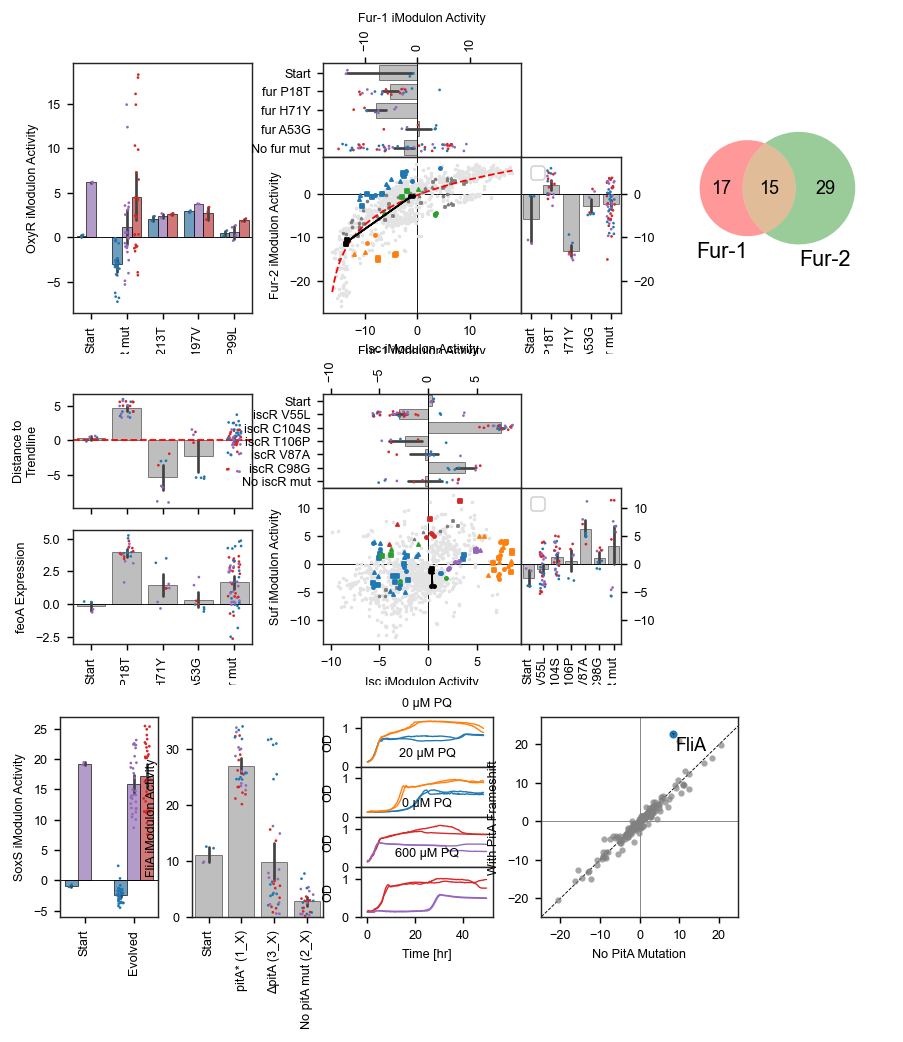

In [6]:
# layout
scale = 0.95 # used to add space between panels in illustrator
fig = plt.figure(figsize = (6.85*scale, 7.5*scale), dpi = 130)
subfigs = fig.subfigures(2, 1, height_ratios = [2, .8])
top_subfigs = subfigs[0].subfigures(2, 3, width_ratios = [1, 1.66, 1])
btm_subfigs = subfigs[1].subfigures(1, 5, width_ratios = [.75, 1, 1, 1.5, .75])

panel_a = top_subfigs[0][0].subplots()
panel_e = top_subfigs[0][2].subplots()
panel_fg = top_subfigs[1][0].subplots(2, 1, sharex = True)

panel_l = btm_subfigs[0].subplots()
panel_m = btm_subfigs[1].subplots()
panel_n = btm_subfigs[2].subplots(4, 1, sharey = True, sharex = True,
                                  gridspec_kw = {'hspace': 0.01})
panel_o = btm_subfigs[3].subplots()


# oxyR - panel A
oxyR_dict = {'Start': ['0_0'],
             'No oxyR mut': ['1_0','1_1','1_2','1_4',
                         '2_0','2_1','2_2','2_3',
                         '3_0','3_1','3_2','3_3','3_4'],
             'oxyR P99L': ['1_3'],
             'oxyR G197V': ['2_1'],
             'oxyR A213T':['1_2']}
im_bar_swarm(ica, ros_meta, 'OxyR', strain_dict = oxyR_dict, 
              ax = panel_a)

# fur - main panels BCD
fur_dict = {'Start':['0_0'],
            'fur P18T':['1_2','1_4', '3_4'],
            'fur H71Y':['1_3'],
            'fur A53G':['3_2'],
            'No fur mut':['1_0', '1_1', '2_0', '2_1',
                           '2_2', '2_3', '3_0', '3_1',
                           '3_3']}
fur_colors = {'Start':'k',
              'fur P18T':'tab:blue',
              'fur H71Y':'tab:orange',
              'fur A53G':'tab:green',
              'No fur mut':'tab:gray'}
fur_axs = scatter_swarm(ica, ros_meta, 'Fur-1', 'Fur-2',
                        strain_dict = fur_dict, colors = fur_colors,
                        fig = top_subfigs[0][1])
# fur - curve in panel C
x_shift, y_shift = get_fur_fit(ica)
fur_axs[1][0].plot(x_shift, y_shift, color = 'r', linewidth = 1,
                   linestyle = '--', label = 'Trendline')

# fur - panel E
fur_gene_dict = fur_venn(ica, panel_e)

# fur - distances to curve, panel F
fur_dist_data = get_fur_distances(ica, ros_meta, x_shift, y_shift)
special_bar_swarm(ica, ros_meta, fur_dist_data, 'Distance',
                  strain_dict = fur_dict, ax = panel_fg[0],
                  dodge = False, zerolinewidth = 0)
panel_fg[0].axhline(color = 'r', linewidth = 1, linestyle = '--')
panel_fg[0].set_ylabel('Distance to\nTrendline', fontsize = 7)

# fur distances - panel G
gene_bar_swarm(ica, ros_meta, ica.name2num('feoA'), 
               strain_dict = fur_dict, ax = panel_fg[1],
               dodge = False)

# iscR
iscr_dict = {'Start':['0_0'],
             'iscR V55L':['1_0', '1_1', '1_2', '1_3', '1_4'],
             'iscR C104S':['2_0', '2_1', '2_2', '2_3'],
             'iscR T106P':['3_1'],
             'iscR V87A':['3_2'],
             'iscR C98G':['3_3'],
             'No iscR mut':['3_0', '3_4']}
iscr_colors = {'Start':'k',
         'iscR V55L':'tab:blue',
         'iscR C104S':'tab:orange',
         'iscR T106P':'tab:green',
         'iscR V87A':'tab:red',
         'iscR C98G':'tab:purple',
         'No iscR mut':'tab:gray'}
iscr_axs = scatter_swarm(ica, ros_meta, 'Isc System', 'Suf System',
                    strain_dict = iscr_dict, colors = iscr_colors,
                         fig = top_subfigs[1][1])
isc_name, suf_name = 'Isc iModulon Activity', 'Suf iModulon Activity'
iscr_axs[1][0].set_xlabel(isc_name)
iscr_axs[0][0].set_xlabel(isc_name)
iscr_axs[1][0].set_ylabel(suf_name)
iscr_axs[1][1].set_ylabel(suf_name)

# soxS
im_bar_swarm(ica, ros_meta, 'Superoxide', ax = panel_l)
panel_l.set_ylabel('SoxS iModulon Activity')

# pitA & FliA
pitA_dict = {'Start':['0_0'],
             'pitA* (1_X)':['1_0', '1_1', '1_2', '1_3', '1_4'],
             'ΔpitA (3_X)':['3_0', '3_1', '3_2', '3_3', '3_4'],
             'No pitA mut (2_X)':['2_0', '2_1', '2_2', '2_3']}
im_bar_swarm(ica, ros_meta, 'FliA', strain_dict = pitA_dict,
             ax = panel_m, dodge = False)

# pitA mutant growth curves
gc_plot(gc_0_0, 0, ax = panel_n[0])
gc_plot(gc_0_0, 20, ax = panel_n[1])
gc_plot(gc_1_0, 0, ax = panel_n[2])
gc_plot(gc_1_0, 600, ax = panel_n[3])

# pitA DiMA
pita_dima_df = pitA_DiMA(pitA_ica, pitA_meta, panel_o)

plt.savefig('output/fig4_raw.pdf')

In [7]:
# to label fig 4E, use the following output:
for k, v in fur_gene_dict.items():
    print(k)
    display(v)

Fur-1 Only


,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,essential,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
b0583,entD,entD,phosphopantetheinyl transferase EntD,Coenzyme transport and metabolism,"RpoD,Crp,Fur",P19925,609459,610079,-,True,...,False,False,NaN,NaN,False,True,3.528960,3.216326,1.226081,True
b1656,sodB,sodB,superoxide dismutase (Fe),Energy production and conversion,"RpoD,ryhB,fnrS,IHF,Crp,NsrR",P0AGD3,1735378,1735959,+,False,...,False,True,4451.0,3567.0,True,True,9.475278,9.512928,1.160733,True
b1682,sufC,sufC;ynhD,Fe-S cluster scaffold complex subunit SufC,Inorganic ion transport and metabolism,"RpoD,NsrR,IHF,IscR,OxyR,Fur,ppGpp",P77499,1761766,1762512,-,False,...,False,True,545.0,259.0,True,True,6.565601,6.213937,1.234267,True
b2675,nrdE,nrdE,ribonucleoside-diphosphate reductase 2 subunit...,Nucleotide transport and metabolism,"RpoD,Fur,IscR,ppGpp,NrdR",P39452,2801348,2803492,+,False,...,False,False,10.5,NaN,True,True,5.605689,4.881500,1.877694,True
b0805,fiu,fiu;ybiL,putative iron siderophore outer membrane trans...,Inorganic ion transport and metabolism,"RpoD,Fur,Crp,rybB",P75780,839249,841531,-,False,...,False,True,129.5,514.0,True,True,6.383400,4.592012,2.194376,True
b0586,entF,entF,apo-serine activating enzyme,"Secondary metabolites biosynthesis, transport,...","RpoD,YbaQ,H-NS,Fnr,Fur",P11454,614157,618038,+,False,...,False,True,32.5,162.0,True,True,5.468597,4.647339,1.572830,True
b1681,sufD,sufD;ynhC,Fe-S cluster scaffold complex subunit SufD,"Post-translational modification, protein turno...","RpoD,NsrR,IHF,IscR,OxyR,Fur,ppGpp",P77689,1760520,1761791,-,False,...,False,True,218.5,179.0,True,True,7.049283,6.244747,1.300103,True
b0803,ybiI,ybiI,zinc finger domain-containing protein YbiI,Signal transduction mechanisms,"RpoS,Lrp",P41039,838190,838456,-,False,...,True,False,3.0,NaN,True,True,5.223423,4.695483,1.306778,True
b0595,entB,entB;entG,enterobactin synthase component B,"Secondary metabolites biosynthesis, transport,...","RpoD,ryhB,Crp,Fur",P0ADI4,627694,628551,+,False,...,False,True,161.5,360.0,True,True,5.947376,5.332772,1.641641,True
b2155,cirA,cirA;cir;feuA,ferric dihyroxybenzoylserine outer membrane tr...,Inorganic ion transport and metabolism,"RpoD,omrB,omrA,Crp,Fur,Hfq,ryhB",P17315,2244778,2246769,-,False,...,False,True,427.5,586.0,True,True,7.420057,6.077157,2.096917,True


Overlap


,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,essential,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
b0591,entS,entS;ybdA,enterobactin exporter EntS,Amino acid transport and metabolism,"RpoD,YdhB,Fur",P24077,622300,623550,+,False,...,False,False,NaN,NaN,False,True,5.005500,4.448661,1.244378,True
b2106,rcnA,rcnA;yohM,Ni(2(+))/Co(2(+)) exporter,"Intracellular trafficking, secretion, and vesi...","RpoD,Fur,RcnR",P76425,2185917,2186741,+,False,...,False,False,NaN,NaN,False,True,6.658085,6.211121,1.888998,True
b2674,nrdI,nrdI;ygaO,dimanganese-tyrosyl radical cofactor maintenan...,Nucleotide transport and metabolism,"RpoD,YidZ,Fur,IscR,ppGpp,NrdR",P0A772,2800965,2801375,+,False,...,False,False,NaN,NaN,False,True,6.251345,5.513240,2.072208,True
b0597,entH,entH;ybdB,proofreading thioesterase in enterobactin bios...,"Secondary metabolites biosynthesis, transport,...","RpoD,ryhB,Crp,Fur",P0A8Y8,629300,629713,+,False,...,False,False,18.0,NaN,True,True,5.807065,5.240372,1.452032,True
b1705,ydiE,ydiE,PF10636 family protein YdiE,Inorganic ion transport and metabolism,NaN,P0ACX9,1789613,1789804,+,False,...,True,False,1.0,NaN,True,True,4.888857,4.852042,1.732803,True
b0592,fepB,fepB,ferric enterobactin ABC transporter periplasmi...,Inorganic ion transport and metabolism,"RpoD,RutR,Fur",P0AEL6,623554,624510,-,False,...,False,True,68.5,218.0,True,True,5.615192,4.973863,1.191589,True
b0588,fepC,fepC,ferric enterobactin ABC transporter ATP bindin...,Inorganic ion transport and metabolism,"RpoD,Fur",P23878,619384,620199,-,False,...,False,False,17.0,NaN,True,True,5.229638,4.811237,1.222483,True
b0589,fepG,fepG,ferric enterobactin ABC transporter membrane s...,Inorganic ion transport and metabolism,"RpoD,Fur",P23877,620196,621188,-,False,...,False,False,NaN,NaN,False,True,4.266241,3.864338,1.294343,True
b0590,fepD,fepD,ferric enterobactin ABC transporter membrane s...,Inorganic ion transport and metabolism,"RpoD,Fur",P23876,621185,622189,-,False,...,False,False,NaN,NaN,False,True,4.964611,4.520092,1.292807,True
b0153,fhuB,fhuB,iron(III) hydroxamate ABC transporter membrane...,Inorganic ion transport and metabolism,"RpoD,Fur",P06972,171462,173444,+,False,...,False,False,NaN,NaN,False,True,4.520881,3.926250,1.100811,True


Fur-2 Only


,gene_name,synonyms,gene_product,COG,regulator,uniprot,start,end,strand,essential,...,y_ome,k_eff,schmidt_prot_med,heckmann_prot_med,proteomics,p1k,p1k_ctrl_log_tpm,p1k_median_log_tpm,p1k_mad_log_tpm,in_iM
b2211,yojI,yojI;yojJ,ABC transporter family protein/microcin J25 ef...,Inorganic ion transport and metabolism,"RpoD,YdcI,Lrp,ppGpp",P33941,2306972,2308615,-,False,...,False,True,3.5,139.0,True,True,6.014600,5.413558,0.925280,True
b2146,preT,preT;yeiT,NAD-dependent dihydropyrimidine dehydrogenase ...,Energy production and conversion,"RpoD,Crp",P76440,2234033,2235271,+,False,...,False,False,NaN,NaN,False,True,1.990620,2.302233,1.084819,True
b0150,fhuA,fhuA;tonA,ferrichrome outer membrane transporter/phage r...,Inorganic ion transport and metabolism,"RpoD,Fur",P06971,167484,169727,+,False,...,False,True,867.0,1722.0,True,True,8.262623,7.689584,1.281706,True
b0151,fhuC,fhuC,iron(III) hydroxamate ABC transporter ATP bind...,Inorganic ion transport and metabolism,"RpoD,Fur",P07821,169778,170575,+,False,...,False,True,NaN,133.0,True,True,6.237114,5.484294,1.192050,True
b3006,exbB,exbB,Ton complex subunit ExbB,"Intracellular trafficking, secretion, and vesi...","RpoD,Fur,Lrp",P0ABU7,3151250,3151984,-,False,...,False,True,697.5,727.0,True,True,8.606542,8.647990,0.877255,True
b1452,yncE,yncE,PQQ-like domain-containing protein YncE,Function unknown,"MarA,ArcA",P76116,1523307,1524368,+,False,...,True,True,3102.0,2135.0,True,True,9.026050,7.967868,1.404127,True
b0468,ybaN,ybaN,conserved inner membrane protein YbaN,Function unknown,GlaR,P0AAR5,490882,491259,+,False,...,True,False,NaN,NaN,False,True,6.404067,6.125759,0.729900,True
b2673,nrdH,nrdH;ygaN,glutaredoxin-like protein,"Post-translational modification, protein turno...","RpoD,YedW,Fur,IscR,ppGpp,NrdR",P0AC65,2800723,2800968,+,False,...,False,False,NaN,NaN,False,True,6.384154,5.929362,2.380030,True
b3408,feoA,feoA,ferrous iron transport protein A,Inorganic ion transport and metabolism,"RpoD,Fur,Fnr,NagC,ArcA",P0AEL3,3540163,3540390,+,False,...,False,False,0.0,NaN,True,True,6.056112,7.301935,1.354488,True
b3410,feoC,feoC;yhgG,ferrous iron transport protein FeoC,Transcription,"RpoD,Fur,Fnr,NagC",P64638,3542728,3542964,+,False,...,True,False,NaN,NaN,False,True,5.223544,6.002032,1.072671,True


## Statistics

### Correlation with PQ

We report the OxyR and SoxS correlations with PQ. Those values are generated below:

In [8]:
# import packages
from scipy.stats import pearsonr
from statsmodels.stats.multitest import fdrcorrection

# calculate correlations
pq_corrs = pd.DataFrame(index = ica.imodulon_names, columns = ['r', 'p'])
for k in ica.imodulon_names:
    pq_corrs.loc[k] = pearsonr(ros_meta.pq, ica.A.loc[k, ros_meta.index])

# run false discovery rate correction
pq_corrs['sig'], pq_corrs['q'] = fdrcorrection(pq_corrs.p)

# sort & remove insignificant values
pq_corrs = pq_corrs.sort_values('r', ascending = False)
sig_pq_corrs = pq_corrs[pq_corrs.sig]

# display results
sig_pq_corrs

,r,p,sig,q
Superoxide,0.718449,2.72273e-17,True,5.47268e-15
OxyR,0.472355,6.12923e-07,True,6.15988e-05
crp KO-1,0.406312,2.48764e-05,True,0.00125004
Tryptophan,0.379858,8.93178e-05,True,0.00299215
FDH-O,0.367361,0.000157459,True,0.00347875
Glycerol,0.358208,0.000235102,True,0.00429596
Propionate,0.354853,0.000271496,True,0.00454755
Salicylic Acid,0.327626,0.000824534,True,0.011838
thrA KO,-0.28138,0.00436556,True,0.0350991
Galactose,-0.284188,0.00397498,True,0.0332905
